In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall librosa -y
!pip uninstall resampy -y
!pip install librosa
!pip install resampy


Found existing installation: librosa 0.10.2.post1
Uninstalling librosa-0.10.2.post1:
  Successfully uninstalled librosa-0.10.2.post1
  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.4 MB/s eta 0:00:00


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/speech/Dataset-No-Augmentation.zip','r') as alpha:
  alpha.extractall('persian-alpha')

In [ ]:
import librosa
import numpy as np
from tensorflow.keras.layers import Dense,Conv1D,MaxPooling1D,Flatten,Dropout,BatchNormalization,LSTM,SimpleRNN
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import L1
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from librosa import load
from librosa.feature import mfcc
import os
import resampy


In [ ]:
def extract_features(file_path, max_pad_len=100):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]

    return mfccs


In [ ]:
audio = []
labels = []
path = '/content/persian-alpha'
a = os.listdir(path)

for i in range(len(a)):
    items = os.listdir(os.path.join(path, str(i)))
    for item in tqdm(items):
        mfccs = extract_features(os.path.join(path, str(i), item))
        audio.append(mfccs)
        labels.append(i)

100%|██████████| 377/377 [00:09<00:00, 39.41it/s]


In [ ]:
audio = np.array(audio)
labels = np.array(labels)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes=11)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(audio, labels, test_size=0.2, random_state=42)

In [ ]:
print(audio.shape,labels.shape)

(3682, 40, 100) (3682, 11)


In [ ]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

model.add(Conv1D(128, activation='relu', kernel_size=3, input_shape=(40, 100), kernel_regularizer=L1(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, activation='relu', kernel_size=3))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(11, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(audio,labels,batch_size=32,epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.1918 - loss: 15.7503 - val_accuracy: 0.3745 - val_loss: 5.5137
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4675 - loss: 4.4022 - val_accuracy: 0.3392 - val_loss: 3.5419
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4707 - loss: 3.1024 - val_accuracy: 0.4505 - val_loss: 2.7659
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5549 - loss: 2.4292 - val_accuracy: 0.5658 - val_loss: 2.4118
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5780 - loss: 2.3674 - val_accuracy: 0.6296 - val_loss: 2.2852
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6124 - loss: 2.3175 - val_accuracy: 0.6147 - val_loss: 2.1611
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5823 - loss: 2.4359 - val_accuracy: 0.5970 - val_loss: 2.2725
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6463 - loss: 2.1278 - val_a

In [ ]:
print(np.unique(labels))

[0. 1.]


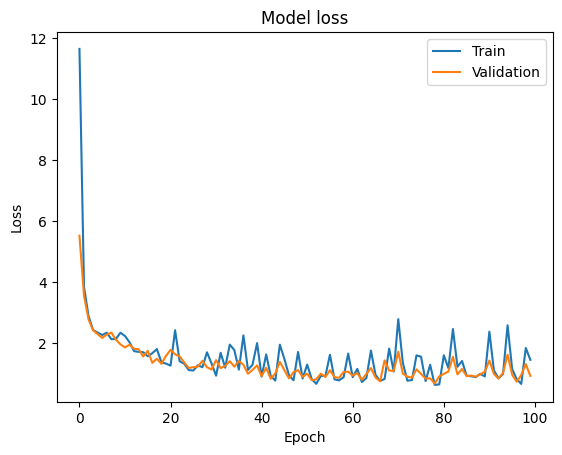

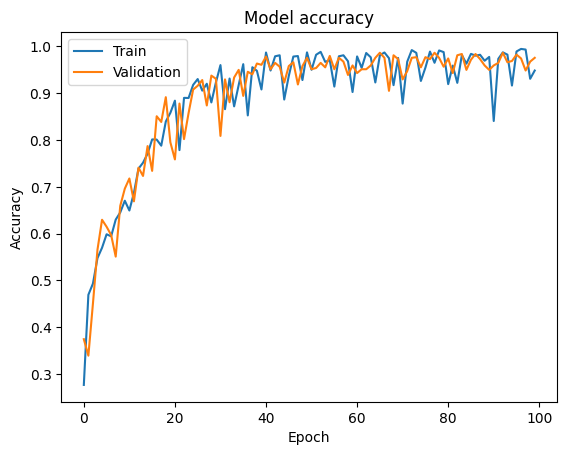

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot the loss and accuracy
plot_loss(history)
plot_accuracy(history)


In [ ]:
model.save('spech2.h5')

In [ ]:
import numpy as np
import librosa

def extract_features(file_path, max_pad_len=100):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]

    return mfccs

file_path = '/content/4-1.m4a'
mfccs = extract_features(file_path)

mfccs = mfccs.reshape(1, 40, 100)


predictions = model.predict(mfccs)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {predicted_class[0]}")


<ipython-input-104-1f9e87fd411a>:5: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: 4


In [ ]:
prediction
